In [1]:
import os
import numpy as np 
import pandas as pd
import tensorflow as tf

from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import roc_auc_score

In [2]:
df_train = pd.read_csv("data/type_encodings.csv")

print(df_train.shape)
df_train.head()

(8430, 19)


,file,type_Bug,type_Dark,type_Dragon,type_Electric,type_Fairy,type_Fighting,type_Fire,type_Flying,type_Ghost,type_Grass,type_Ground,type_Ice,type_Normal,type_Poison,type_Psychic,type_Rock,type_Steel,type_Water
0,0001.png,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,0002.png,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,0003.png,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,0004.png,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0005.png,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [3]:
y_tests = df_train.iloc[:151, 1:]

print(y_tests.shape)
y_tests.head()

(151, 18)


,type_Bug,type_Dark,type_Dragon,type_Electric,type_Fairy,type_Fighting,type_Fire,type_Flying,type_Ghost,type_Grass,type_Ground,type_Ice,type_Normal,type_Poison,type_Psychic,type_Rock,type_Steel,type_Water
0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [4]:
image_size = 450
batch_size = 32

In [5]:
def build_decoder(with_labels=True, target_size=(image_size, image_size)):
    def decode(path):
        file_bytes = tf.io.read_file(path)

        image = tf.image.decode_png(file_bytes, channels=3)
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.image.resize(image, target_size)
        image = preprocess_input(image)
        
        return image
    
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    
    return decode_with_labels if with_labels else decode

In [6]:
def build_augmenter(with_labels=True):
    def augment(image):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_saturation(image, 0.8, 1.2)
        image = tf.image.random_brightness(image, 0.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)
        image = tf.image.random_hue(image, 0.2)
        
        return image
    

    def augment_with_labels(image, label):
        return augment(image), label
    
    
    return augment_with_labels if with_labels else augment

In [7]:
def build_dataset(paths, labels=None, bsize=32, decode_function=None, augment_function=None, augment=True):
    if decode_function is None:
        decode_function = build_decoder(labels is not None)

    if augment_function is None:
        augment_function = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dataset = tf.data.Dataset.from_tensor_slices(slices)  
    dataset = dataset.map(decode_function, num_parallel_calls=AUTO)
    dataset = dataset.map(augment_function, num_parallel_calls=AUTO) if augment else dataset

    dataset = dataset.batch(bsize).prefetch(AUTO) 

    return dataset

In [8]:
model = tf.keras.models.load_model('model.h5')

In [9]:
load_dir = "data/images/test/"

test_paths = [os.path.join(load_dir, path) for path in os.listdir(load_dir)]

test_decoder = build_decoder(with_labels=False, target_size=(image_size, image_size))

data_test = build_dataset(test_paths, bsize=batch_size, augment=False, decode_function=test_decoder)

In [10]:
y_preds = model.predict(data_test, verbose=1)

5/5 [==============================] - 33s 6s/step


In [11]:
df_test = pd.DataFrame([os.listdir(load_dir)] + [y_pred for y_pred in list(zip(*y_preds))], df_train.columns).T

print(df_test.shape)
df_test.head(9)

(151, 19)


,file,type_Bug,type_Dark,type_Dragon,type_Electric,type_Fairy,type_Fighting,type_Fire,type_Flying,type_Ghost,type_Grass,type_Ground,type_Ice,type_Normal,type_Poison,type_Psychic,type_Rock,type_Steel,type_Water
0,0001-Bulbasaur.png,0.000024,0.000104,0.000031,0.000006,0.000032,0.000077,0.000037,0.000039,0.000164,0.998991,0.000436,0.000508,0.000073,0.999847,0.000225,0.000273,0.000009,0.000111
1,0002-Ivysaur.png,0.000019,0.000012,0.000003,0.000030,0.000002,0.000010,0.000005,0.000006,0.000028,0.999998,0.000001,0.000030,0.000002,0.999964,0.000011,0.000005,0.000001,0.000005
2,0003-Venusaur.png,0.000102,0.000045,0.000027,0.000003,0.000009,0.000029,0.000019,0.000158,0.000131,0.999993,0.000025,0.000162,0.000018,0.999904,0.000024,0.000031,0.000003,0.000026
3,0004-Charmander.png,0.000003,0.000036,0.000006,0.000216,0.000003,0.000093,0.999942,0.000007,0.000000,0.000009,0.000034,0.000114,0.000009,0.000004,0.000367,0.000001,0.000001,0.000096
4,0005-Charmeleon.png,0.000021,0.000094,0.000004,0.000086,0.000003,0.000307,0.999990,0.000193,0.000001,0.000002,0.000111,0.000051,0.000005,0.000004,0.000425,0.000004,0.000001,0.000010
5,0006-Charizard.png,0.000000,0.000020,0.000165,0.000001,0.000000,0.000013,0.999999,0.995000,0.000000,0.000000,0.000015,0.000013,0.000001,0.000001,0.000003,0.000044,0.000000,0.000002
6,0007-Squirtle.png,0.000045,0.000001,0.000002,0.000000,0.000003,0.000085,0.000001,0.000008,0.000000,0.000024,0.000055,0.000022,0.000013,0.000865,0.000020,0.000213,0.000000,0.999993
7,0008-Wartortle.png,0.000038,0.000001,0.000005,0.000008,0.000009,0.000005,0.000000,0.000014,0.000000,0.000006,0.000018,0.000049,0.000004,0.000087,0.000020,0.000102,0.000003,0.999998
8,0009-Blastoise.png,0.000022,0.000001,0.000004,0.000001,0.000004,0.000002,0.000001,0.000011,0.000000,0.000004,0.021977,0.000355,0.000049,0.000005,0.000336,0.479901,0.000011,0.998882


In [12]:
type_dict = df_test.to_dict(orient='list')

type_dict['predicted_types'] = []

for i in range(len(type_dict['file'])):
    types = [key for key in type_dict.keys() if key not in ['file', 'predicted_types']]
    type_dict['predicted_types'].append([tpe[5:] for tpe in types if type_dict[tpe][i] > 0.66])
    
type_dict['predicted_types'] = [" + ".join(row) for row in type_dict['predicted_types']]

df_test = pd.DataFrame.from_dict(type_dict)

cols = df_test.columns.tolist()
cols = [cols[0]] + [cols[-1]] + cols[1:-1]

df_test = df_test[cols]

print(df_test.shape)
df_test.head(9)

(151, 20)


,file,predicted_types,type_Bug,type_Dark,type_Dragon,type_Electric,type_Fairy,type_Fighting,type_Fire,type_Flying,type_Ghost,type_Grass,type_Ground,type_Ice,type_Normal,type_Poison,type_Psychic,type_Rock,type_Steel,type_Water
0,0001-Bulbasaur.png,Grass + Poison,2.439883e-05,1.042342e-04,0.000031,5.567040e-06,3.220753e-05,0.000077,3.708733e-05,0.000039,1.639128e-04,9.989911e-01,0.000436,0.000508,7.332437e-05,9.998471e-01,0.000225,2.734959e-04,9.048485e-06,0.000111
1,0002-Ivysaur.png,Grass + Poison,1.884469e-05,1.245311e-05,0.000003,3.012339e-05,1.993383e-06,0.000010,4.752636e-06,0.000006,2.765219e-05,9.999976e-01,0.000001,0.000030,1.514515e-06,9.999636e-01,0.000011,4.554340e-06,8.145749e-07,0.000005
2,0003-Venusaur.png,Grass + Poison,1.019022e-04,4.463954e-05,0.000027,3.475091e-06,8.634413e-06,0.000029,1.854072e-05,0.000158,1.308620e-04,9.999930e-01,0.000025,0.000162,1.771173e-05,9.999039e-01,0.000024,3.143631e-05,2.767993e-06,0.000026
3,0004-Charmander.png,Fire,3.483097e-06,3.583934e-05,0.000006,2.158582e-04,2.903422e-06,0.000093,9.999425e-01,0.000007,3.040363e-07,9.218279e-06,0.000034,0.000114,8.500598e-06,3.797423e-06,0.000367,5.994185e-07,7.376863e-07,0.000096
4,0005-Charmeleon.png,Fire,2.140448e-05,9.448064e-05,0.000004,8.586716e-05,2.680795e-06,0.000307,9.999897e-01,0.000193,6.786125e-07,1.993273e-06,0.000111,0.000051,5.427277e-06,4.320013e-06,0.000425,3.700128e-06,1.373273e-06,0.000010
5,0006-Charizard.png,Fire + Flying,2.598641e-07,1.958524e-05,0.000165,7.067101e-07,4.971288e-07,0.000013,9.999992e-01,0.995000,7.025300e-08,3.782588e-07,0.000015,0.000013,6.200643e-07,8.314581e-07,0.000003,4.395233e-05,1.193916e-07,0.000002
6,0007-Squirtle.png,Water,4.475391e-05,9.270563e-07,0.000002,1.737121e-07,2.653642e-06,0.000085,8.092539e-07,0.000008,9.864534e-08,2.389679e-05,0.000055,0.000022,1.324180e-05,8.647144e-04,0.000020,2.128482e-04,2.515535e-07,0.999993
7,0008-Wartortle.png,Water,3.816027e-05,1.009098e-06,0.000005,7.694804e-06,8.954521e-06,0.000005,3.536957e-07,0.000014,4.003073e-07,5.629037e-06,0.000018,0.000049,3.615163e-06,8.720748e-05,0.000020,1.018957e-04,2.542889e-06,0.999998
8,0009-Blastoise.png,Water,2.154764e-05,8.928244e-07,0.000004,6.289999e-07,3.967925e-06,0.000002,7.427726e-07,0.000011,2.087171e-07,4.259866e-06,0.021977,0.000355,4.937651e-05,4.510175e-06,0.000336,4.799012e-01,1.103896e-05,0.998882


In [13]:
df_test.to_csv("data/predictions.csv", index=False)

In [14]:
tests = pd.DataFrame(y_tests, columns=df_train.columns[1:]).drop(columns=['type_Dark'])
preds = pd.DataFrame(y_preds, columns=df_train.columns[1:]).drop(columns=['type_Dark'])

roc_auc_score(tests, preds, average='weighted', multi_class='ovo')

1.0

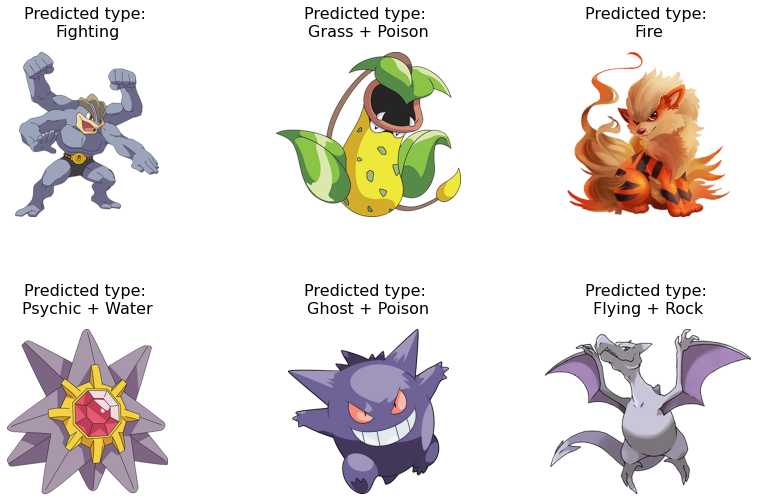

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

rows = 2
cols = 3
axes = []

paths = ['0068-Machamp.png', '0071-Victreebel.png','0059-Arcanine.png', 
         '0121-Starmie.png', '0094-Gengar.png', '0142-Aerodactyl.png']

fig = plt.figure()

for path in paths:
    image = mpimg.imread('data/images/test/' + path)
    title = ("Predicted type: \n" + df_test[df_test['file'] == path]['predicted_types'].item())
    
    axes.append(fig.add_subplot(rows, cols, paths.index(path)+1))
    axes[-1].set_axis_off()
    axes[-1].set_title(title, fontsize=16, pad=16)
    
    plt.imshow(image)

fig.tight_layout()
fig.set_size_inches(12, 8)

plt.savefig('../images/type_predictions.png', dpi=100)
plt.show()